# Question 2

This notebook investigates the pulsatility data.

In [1]:
import os

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sphincter.data_preparation import load_prepared_data

In [2]:
PLOTS_DIR = os.path.join("..", "plots")

full_data = load_prepared_data("../data/prepared/q2.json")
no_hyper_data = load_prepared_data("../data/prepared/q2-no-hyper.json")

mts, mts_full = no_hyper_data.measurements, full_data.measurements

In [3]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")

The next cell plots the full dataset

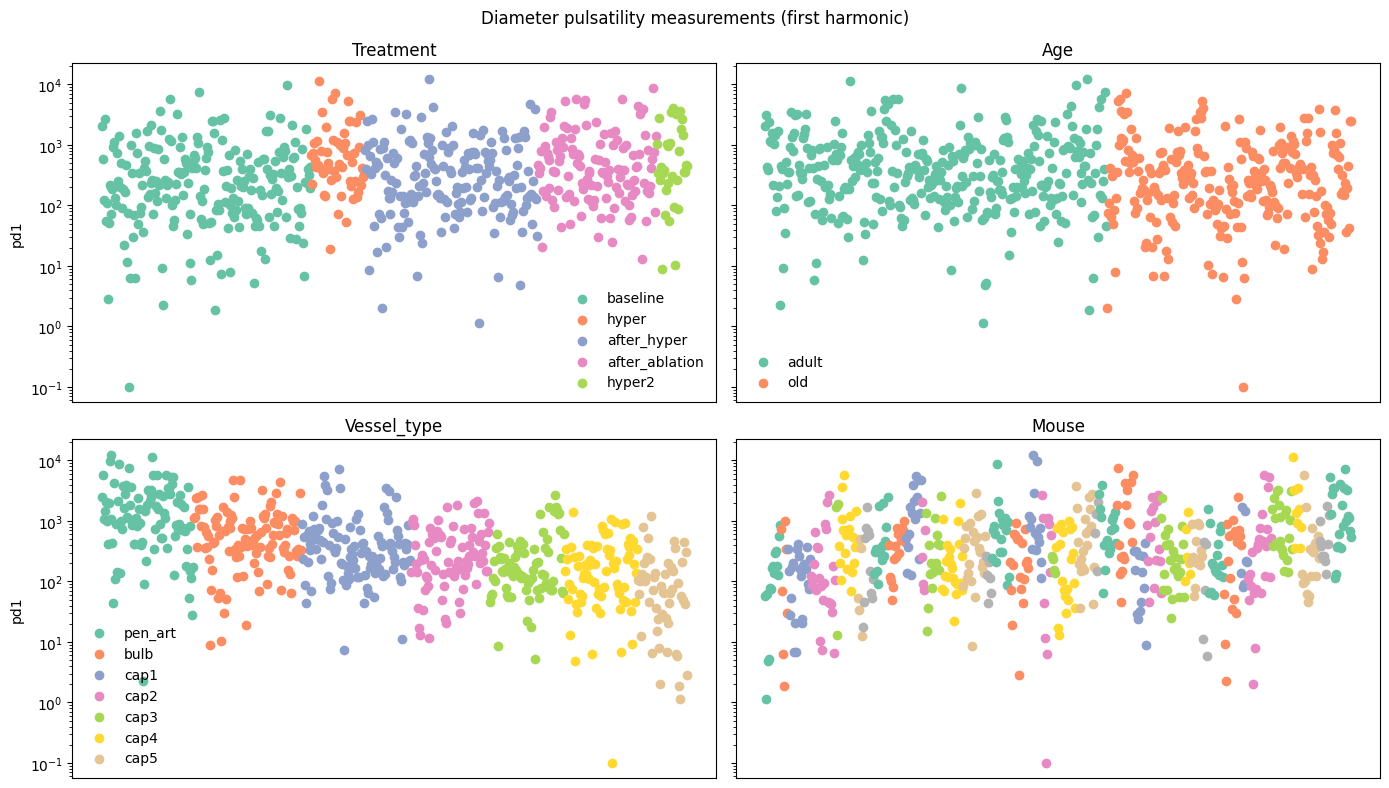

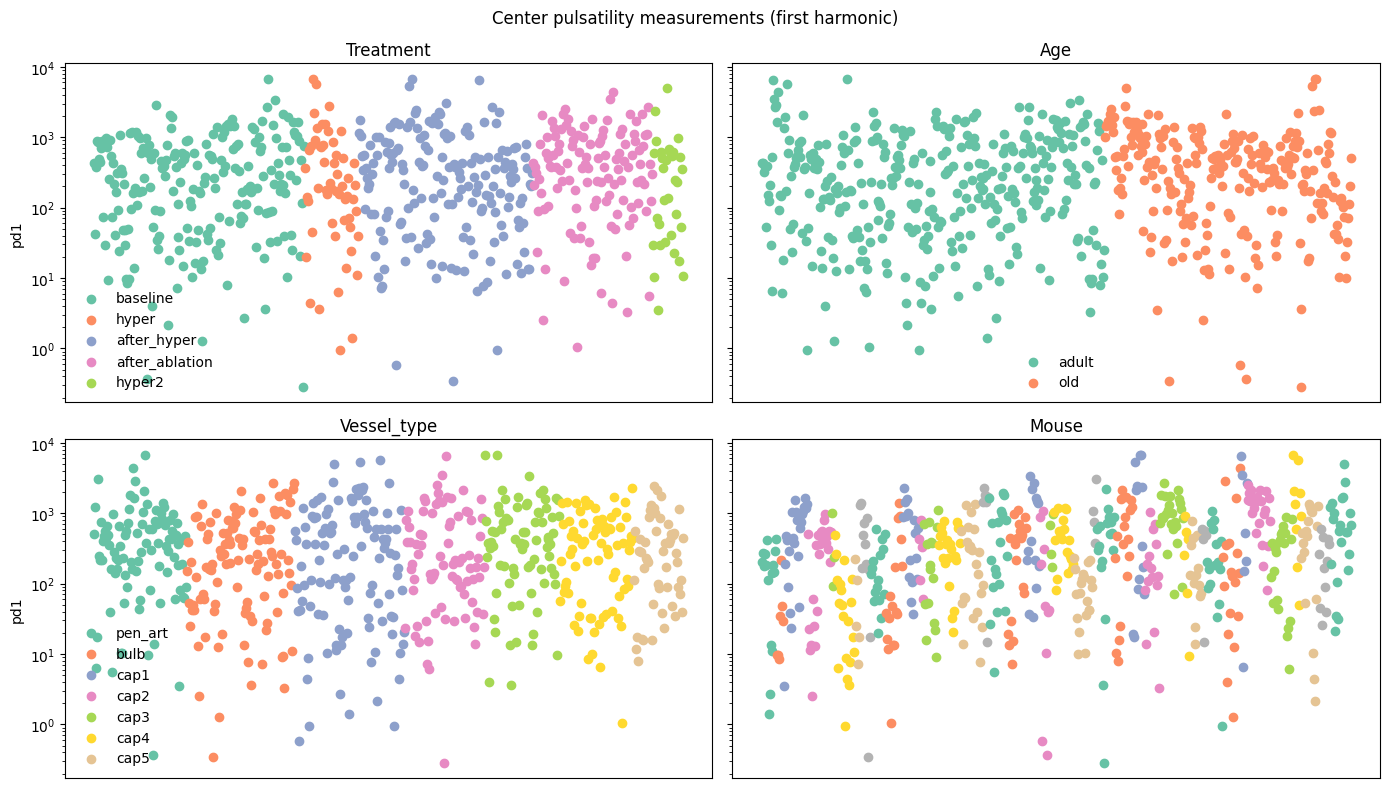

In [4]:
def plot_obs_cat(ax, obs, catcol, cmap, extra_obs=None, **scatter_kwargs):
    colors = list(cmap.colors)
    d_dict = {"obs": obs, "cat": catcol}
    if extra_obs is not None:
        d_dict["extra"] = extra_obs
    d = pd.DataFrame(d_dict).sort_values("cat").assign(x=np.linspace(0, 1, len(obs)))
    scts = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        color = colors[i % len(colors)]
        scts.append(ax.scatter(subdf["x"], subdf["obs"], label=cat, color=color, **scatter_kwargs))
        if extra_obs is not None:
            scts.append(ax.scatter(subdf["x"], subdf["extra"], marker="x", label=extra_obs.name, color="black"))            
    return scts



obs = mts_full["pd1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts_full[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()

obs = mts_full["pc1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts_full[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Center pulsatility measurements (first harmonic)");
f.tight_layout()

In order to go one step at a time I'm going to first look at the data excluding the hypertension case. 

Here's the same plot for this reduced dataset.

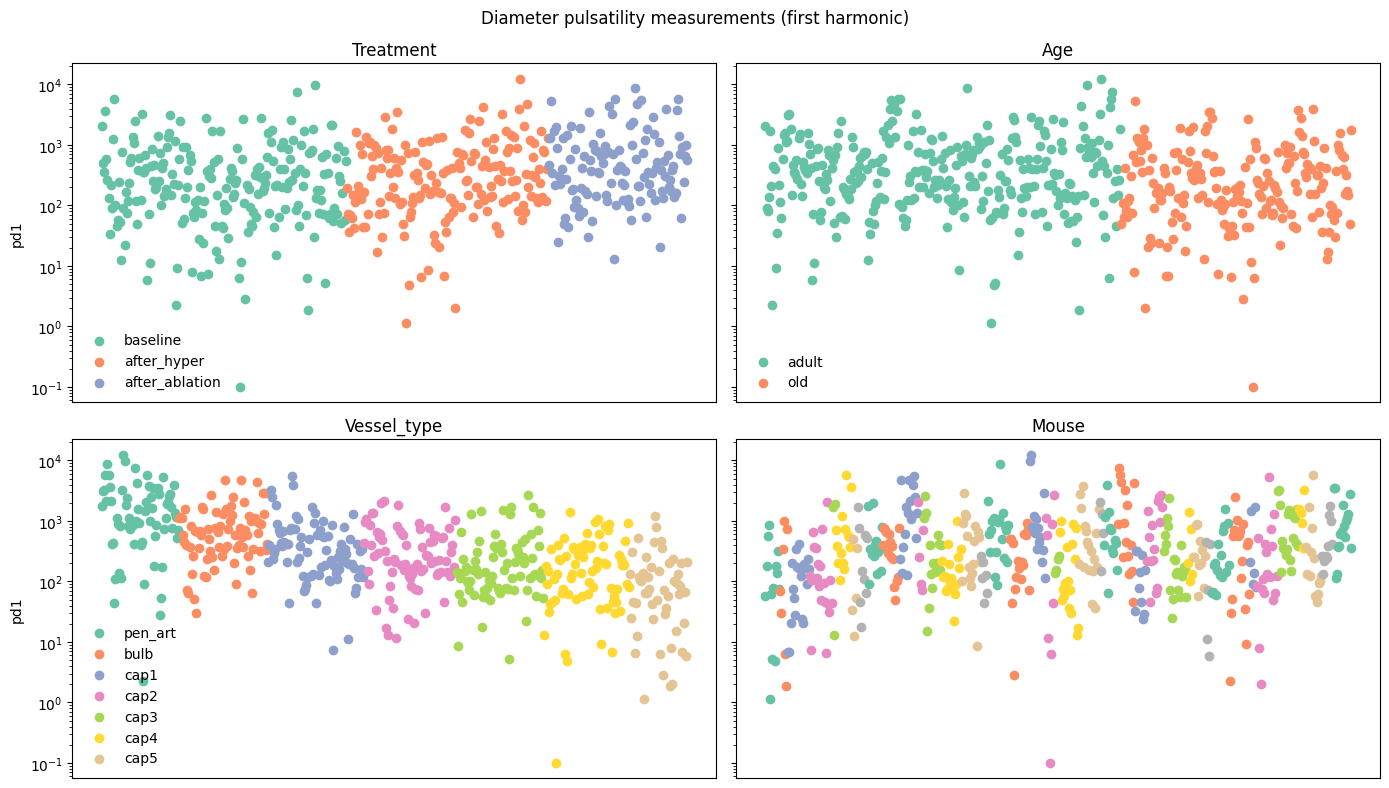

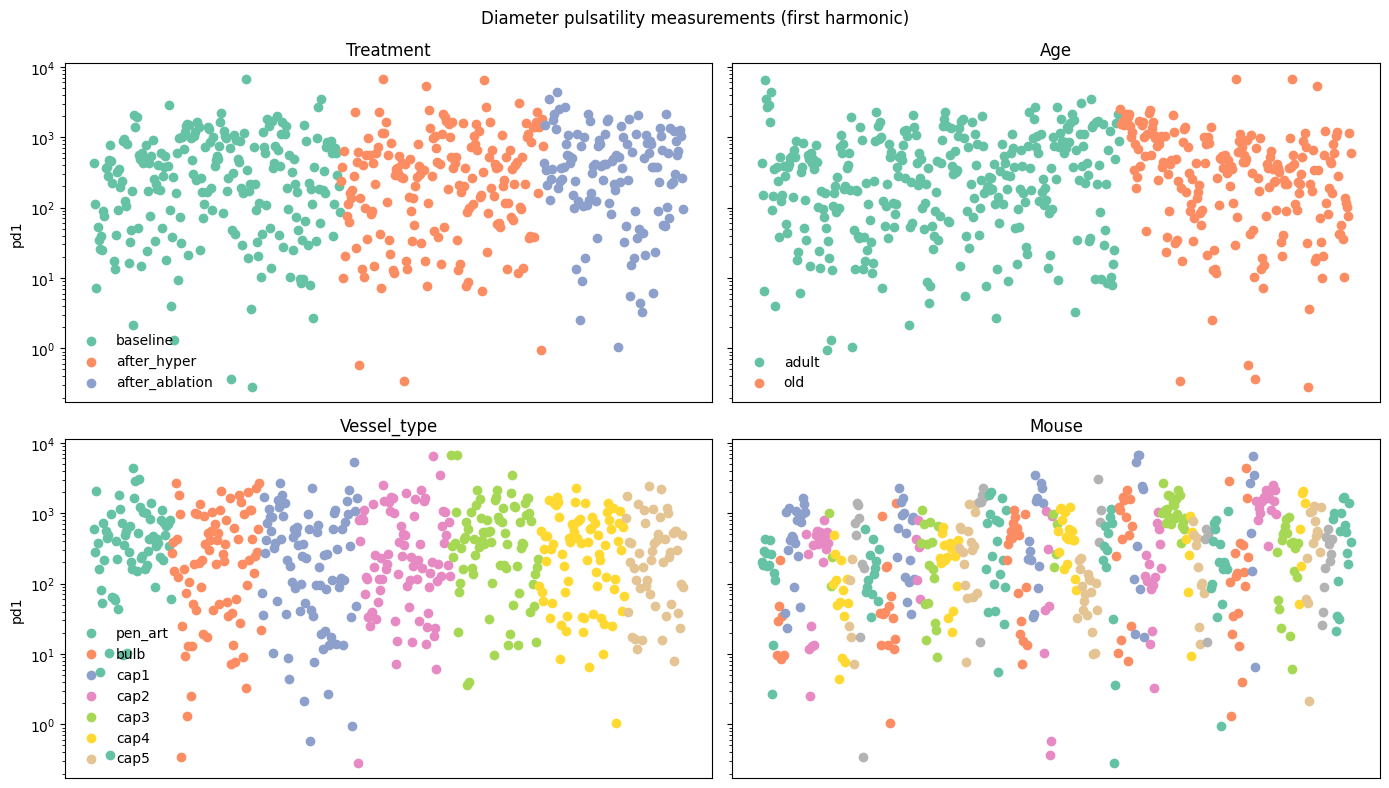

In [5]:
obs = mts["pd1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-diameter-measurements.png"), bbox_inches="tight")

obs = mts["pc1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = mts[col]
    sct = plot_obs_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-center-measurements.png"), bbox_inches="tight")

There is a clear pattern for the diameter power harmonics to get lower with the order of the vessel.

The treatment regime seems to make the diameter measurements closer together and somewhat higher.

The center power harmonics have an interesting cluster: one old mice seems to have had consistently high measurements.

The next cell gets that mouse's id and displays all of its center power harmonic measurements.


In [6]:
mts.loc[
    lambda df: df["mouse"] == mts.groupby("mouse", observed=True)["pc1"].max().idxmax(),
    ["age", "mouse", "vessel_type", "pd1", "pc1", "pressure_d"]
]

,age,mouse,vessel_type,pd1,pc1,pressure_d
1155,old,200820,bulb,155.643095,17.588219,44.730375
1143,old,200820,bulb,314.829290,19.476556,47.302121
1156,old,200820,cap1,321.307043,5394.333862,44.690442
1144,old,200820,cap1,79.023271,339.436304,47.258566
1158,old,200820,cap3,144.224951,6749.712200,44.807104
1146,old,200820,cap3,45.345324,6612.926165,47.289996
1159,old,200820,cap4,32.766022,114.552898,44.836661
1147,old,200820,cap4,275.720747,83.570348,46.707032
1160,old,200820,cap5,24.215271,2424.941861,44.777698
1148,old,200820,cap5,28.978164,2171.428497,46.434238


There is also a blood pressure measurement for each datapoint. The next plot shows that there isn't an obvious correlation between pressure and our measurements.

NOTE: try coarsening the data by binning.

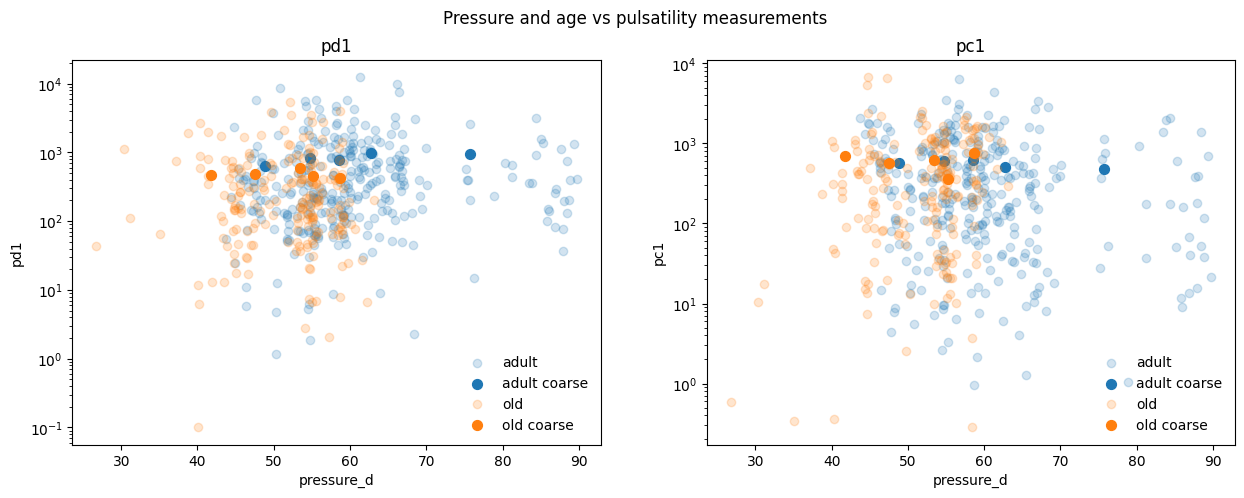

In [7]:
f, axes = plt.subplots(1, 2, figsize=[15, 5]);

col = "pressure_d"
groupcol = "age"


def plots_with_bins_and_groups(axes, mts, col, groupcol):
    for ax, ycol in zip(axes, ["pd1", "pc1"]):
        for treatment, subdf in mts.groupby(groupcol, observed=True):
            bins = pd.qcut(subdf[col], 5)
            coarse = subdf.groupby(bins, observed=True)[[col, ycol]].mean()
            sct = ax.scatter(subdf[col], subdf[ycol], label=treatment, alpha=0.2);
            ax.scatter(
                coarse[col], 
                coarse[ycol], 
                marker="o", 
                label=treatment + " coarse", 
                color=sct.get_facecolor(),
                alpha=1,
                s=50
            );
        ax.legend(frameon=False)
        ax.semilogy();
        ax.set(title=ycol, xlabel=col, ylabel=ycol);
        # ax.semilogx();
    return axes

plots_with_bins_and_groups(axes, mts, col, groupcol);
f.suptitle("Pressure and age vs pulsatility measurements");
f.savefig(os.path.join(PLOTS_DIR, "pressure-data.png"), bbox_inches="tight")

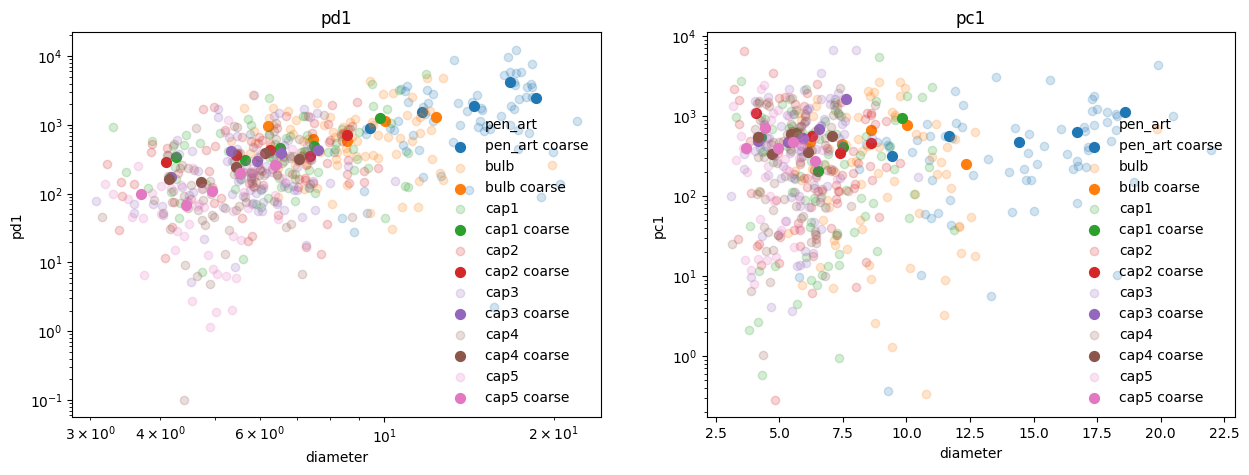

In [26]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])

plots_with_bins_and_groups(axes, mts, "diameter", "vessel_type");
axes[0].semilogy();
axes[0].semilogx();
f.savefig(os.path.join(PLOTS_DIR, "q2-diameter-data.png"), bbox_inches="tight")

The first model I fit to this dataset predicts diameter and center power harmonics independently and in the same way, using the sum of four (also independent) parameters: an intercept $\mu$, an age effect $\alpha^{age}$ a treatment effect $\alpha^{treatment}$ and a vessel type effect $\alpha^{vessel\ type}$. The model creates a linear predictor out of these parameters for each measurement and fits it using an exponential GLM.

I called this model the "basic" model.

The next cell loads the results of fitting the basic model and runs a diagnostic to estimate its out of sample predictive performance. The main output metric (`elpd_loo`) is in principle absolute, representing the estimated total out of sample log likelihood under leave-one-out cross validation. However, this doesn't mean too much in isolation as it isn't clear in advance what would be a good without another model to compare with. Still, the fact that the check runs without warnings is a good sign, indicating that there weren't many very influential observations.

In [9]:
idatas = {
    "q2-basic": az.InferenceData.from_zarr(os.path.join("..", "inferences", "q2-basic", "idata")),
    "q2-interaction": az.InferenceData.from_zarr(os.path.join("..", "inferences", "q2-interaction", "idata")),
    "q2-pressure": az.InferenceData.from_zarr(os.path.join("..", "inferences", "q2-pressure", "idata")),
    "q2-pressure-no-age": az.InferenceData.from_zarr(os.path.join("..", "inferences", "q2-pressure-no-age", "idata"))
}
cmp = az.compare(idatas)
cmp

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
q2-pressure,0,-486.152670,34.836393,0.000000,5.478289e-01,46.912275,0.000000,False,log
q2-basic,1,-486.377527,28.929631,0.224857,3.494149e-01,46.212313,3.636130,False,log
q2-interaction,2,-489.079415,42.296122,2.926745,3.499804e-17,46.259298,3.997678,False,log
q2-pressure-no-age,3,-500.128837,28.007704,13.976166,1.027562e-01,46.363324,6.809564,False,log


In [10]:
for name, idata in idatas.items():
    print(f"Number of diverging transitions for {name} model: " +  str(idata.sample_stats.diverging.values.sum()))

Number of diverging transitions for q2-basic model: 0
Number of diverging transitions for q2-interaction model: 0
Number of diverging transitions for q2-pressure model: 0
Number of diverging transitions for q2-pressure-no-age model: 0


In [11]:
loo = az.loo(idatas["q2-pressure"], pointwise=True)
loo

Computed from 4000 posterior samples and 514 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -486.15    46.91
p_loo       34.84        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      509   99.0%
 (0.5, 0.7]   (ok)          5    1.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


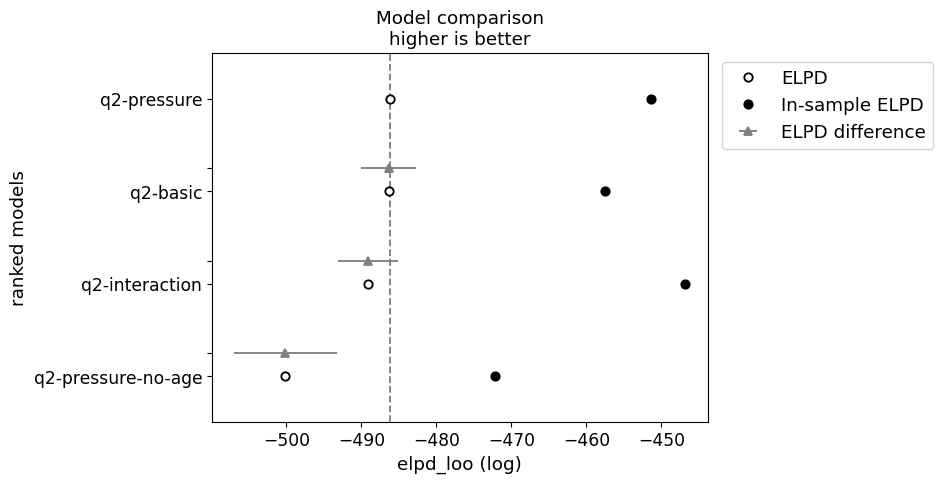

In [12]:
f, ax = plt.subplots()
az.plot_compare(cmp, insample_dev=True, ax=ax, plot_standard_error=False);
f.savefig(os.path.join(PLOTS_DIR, "q2-elpd-comparison.png"), bbox_inches="tight")

The next cell plots the marginal distributions of the basic model's main parameters.

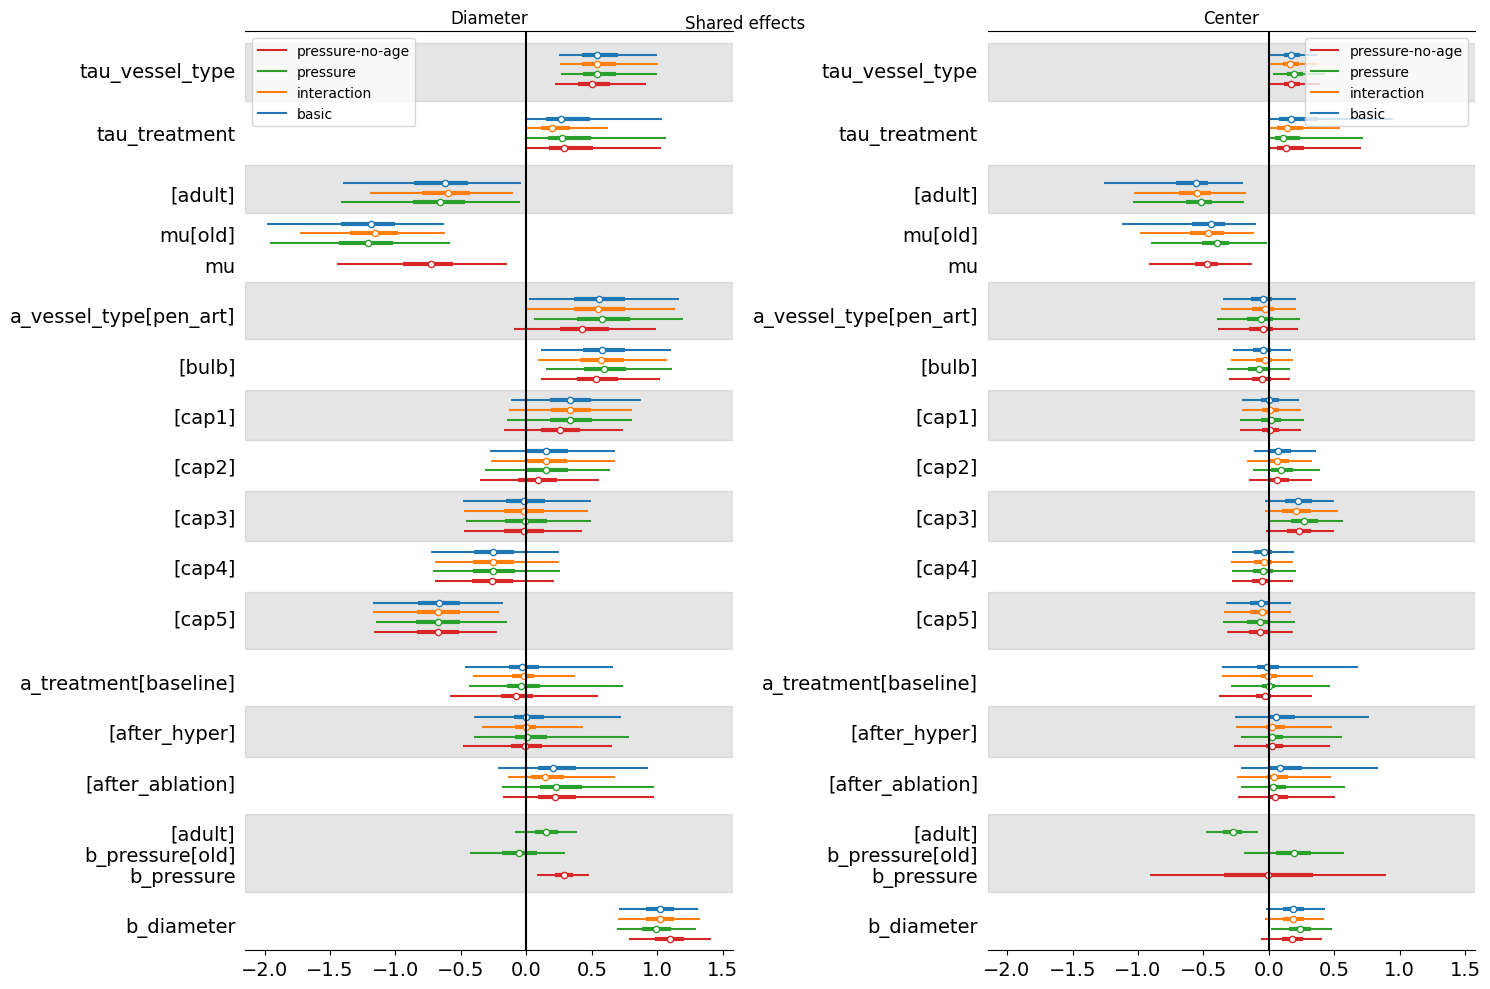

In [13]:
vars = ["tau_vessel_type", "tau_treatment", "mu", "a_vessel_type", "a_treatment", "b_pressure", "b_diameter"]
f, axes = plt.subplots(1, 2, figsize=[15, 10], sharex=True)
for ax, mt in zip(axes, ["diameter", "center"]):
    az.plot_forest(
        [idatas["q2-basic"], idatas["q2-interaction"], idatas["q2-pressure"], idatas["q2-pressure-no-age"]],
        model_names=["basic", "interaction", "pressure", "pressure-no-age"], 
        combined=True, 
        ax=ax,
        var_names=vars,
        coords={"measurement_type": mt}
    );
    ax.axvline(0, color="black")
    ax.set(title=mt.capitalize())
f.tight_layout()
f.suptitle("Shared effects")
f.savefig(os.path.join(PLOTS_DIR, "q2-effects.png"), bbox_inches="tight")

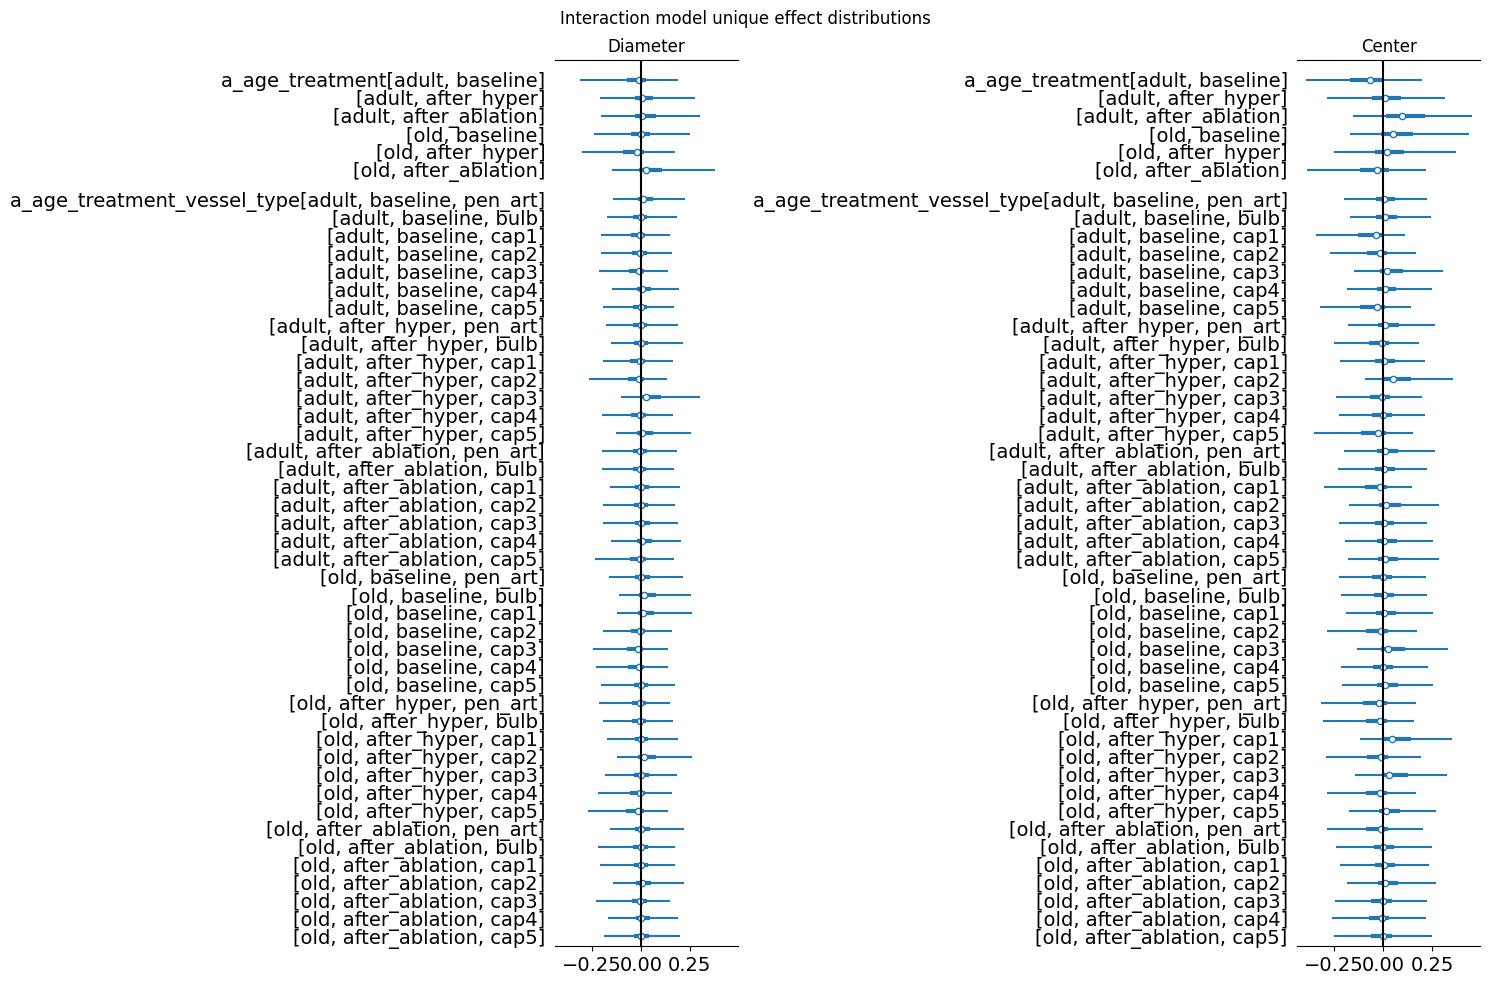

In [14]:
vars = ["a_age_treatment", "a_age_treatment_vessel_type"]
f, axes = plt.subplots(1, 2, figsize=[15, 10], sharex=True)
for ax, mt in zip(axes, ["diameter", "center"]):
    az.plot_forest(idatas["q2-interaction"], combined=True, ax=ax, var_names=vars, coords={"measurement_type": mt});
    ax.axvline(0, color="black")
    ax.set(title=mt.capitalize())
f.suptitle("Interaction model unique effect distributions")
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "q2-interaction-effects.png"), bbox_inches="tight")

The next cell does a posterior predictive check, comparing measurements simulated using the model with the actually realised observations.

This shows an overall fairly good fit, though there are quite a few extreme center measurements that the model can't capture, and it seems to underfit for some mice as a result.

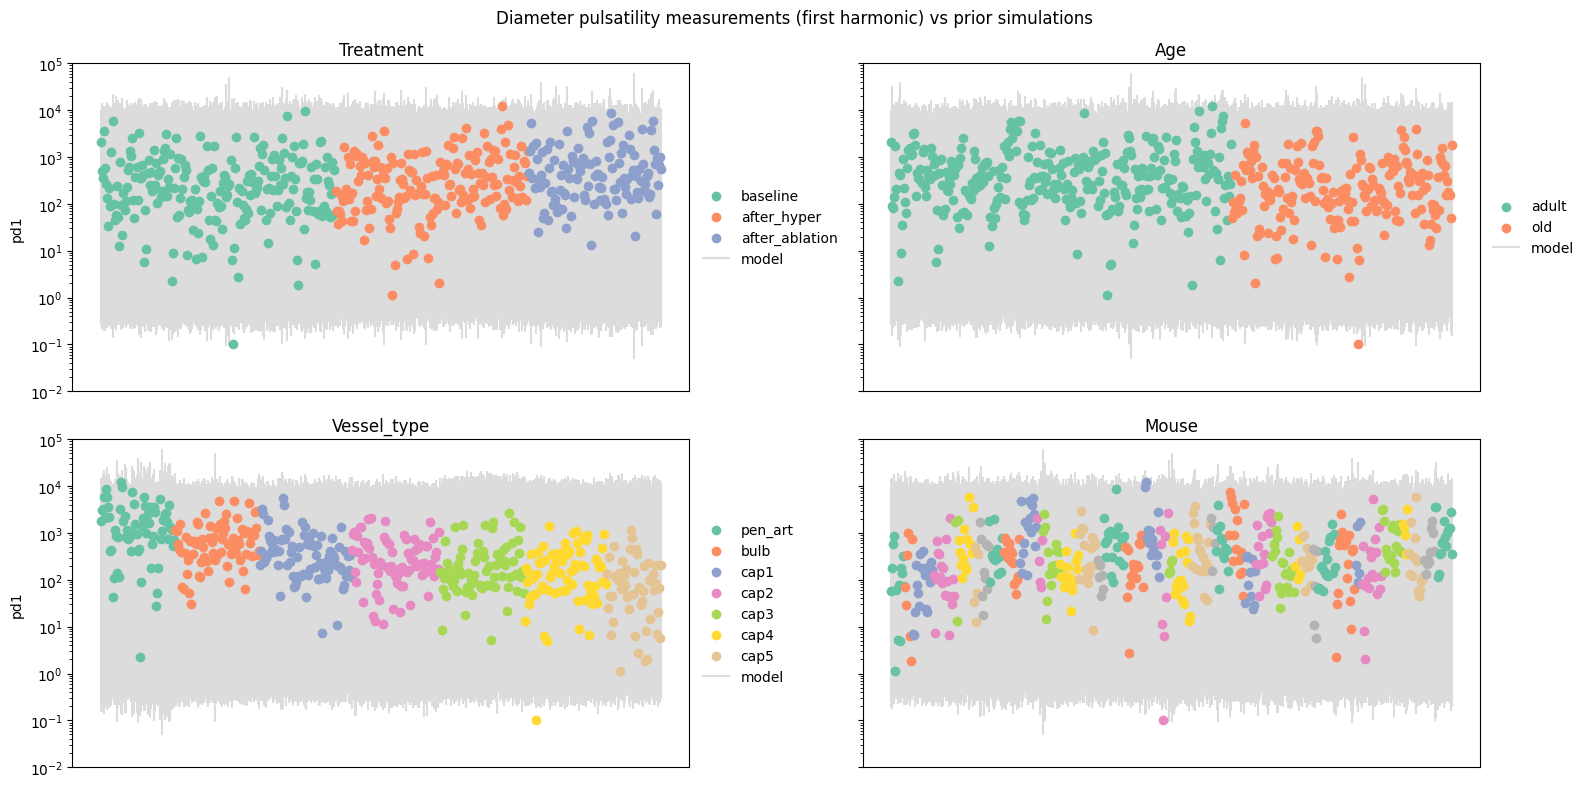

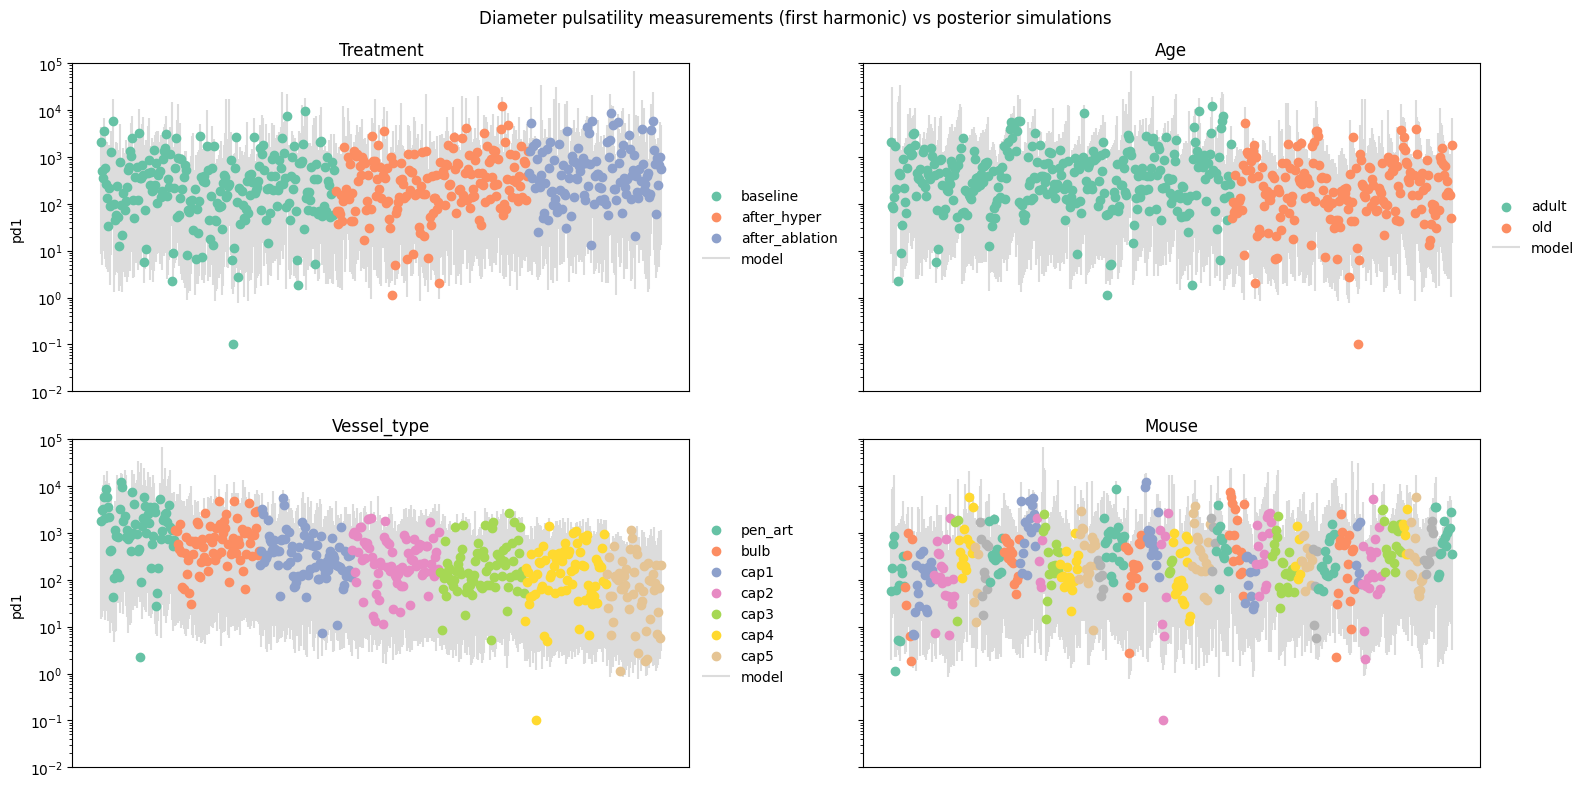

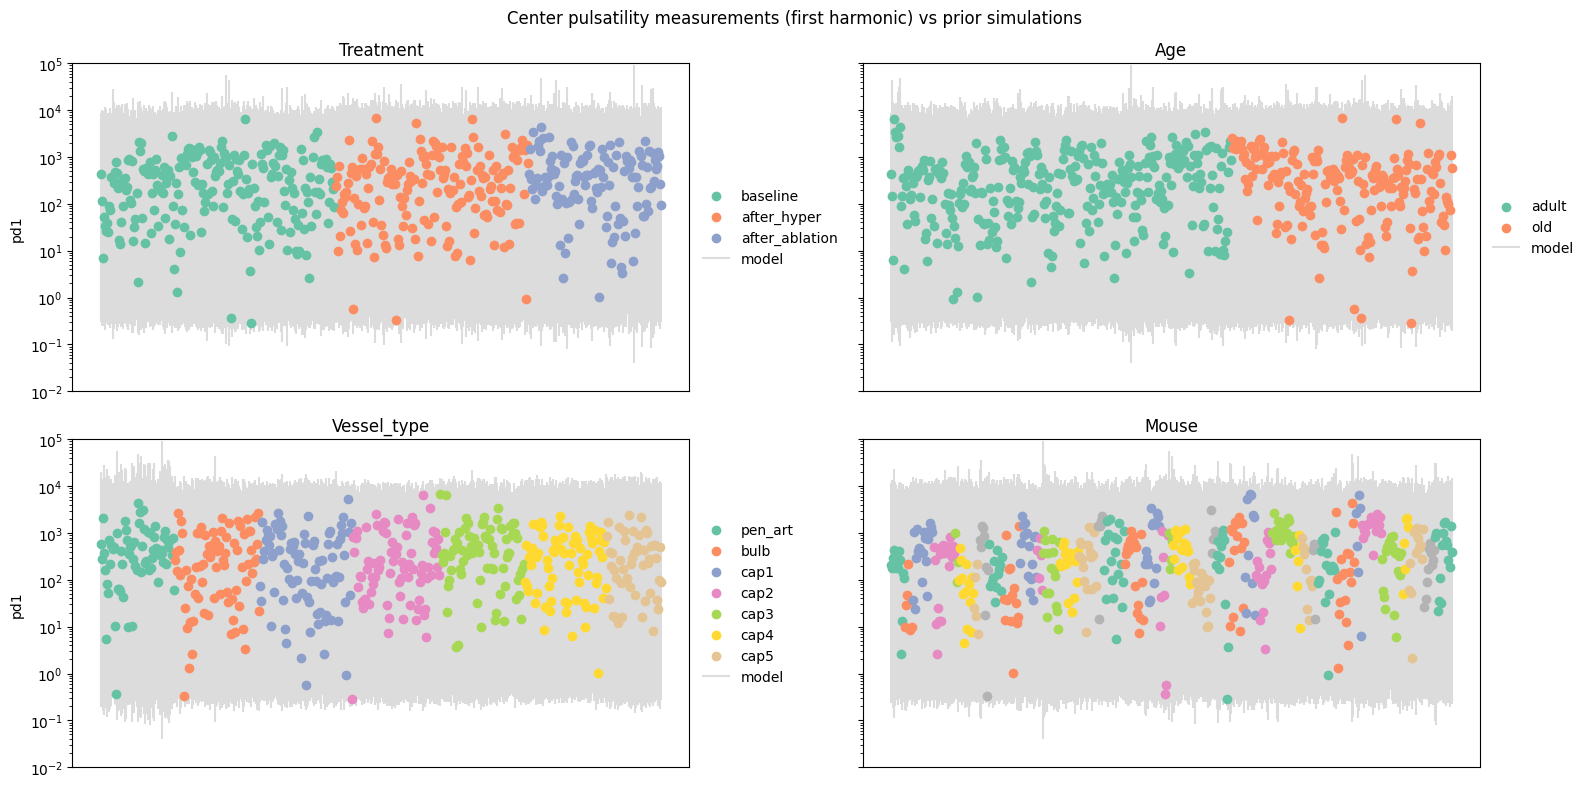

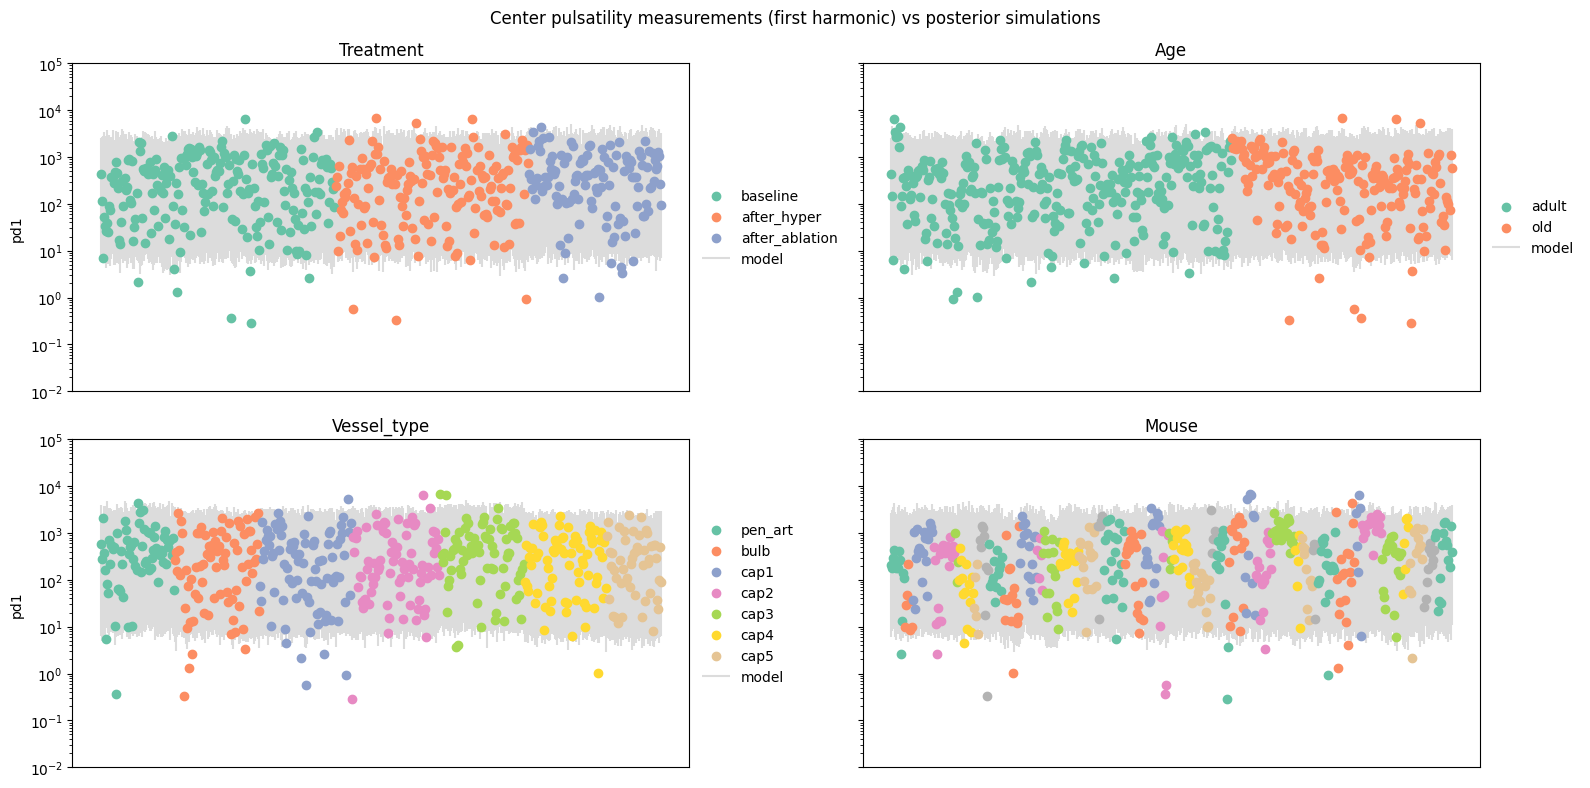

In [15]:
def plot_lines_cat(ax, yrep, catcol, cmap, **vlines_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame(
        {
            "cat": catcol,
            "q1": yrep.quantile(0.01, dim=["chain", "draw"]).values,
            "q99": yrep.quantile(0.99, dim=["chain", "draw"]).values,
        }
    ).sort_values("cat").assign(x=np.linspace(0, 1, len(catcol)))
    linesets = []
    for i, (cat, subdf) in enumerate(d.groupby("cat", observed=True)):
        lines = ax.vlines(subdf["x"], subdf["q1"], subdf["q99"], color="gainsboro", **vlines_kwargs)
    return lines

def plot_ppc(axes, mts, obs, yrep, cmap):
    for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
        catcol = mts[col].cat.remove_unused_categories()
        scts = plot_obs_cat(ax, obs, catcol, cmap)
        lines = plot_lines_cat(ax, yrep, catcol, cmap, zorder=0, label="model")
        if col != "mouse":
            ax.legend(scts + [lines], list(catcol.cat.categories) + ["model"], frameon=False, bbox_to_anchor=[1,0.5], loc="center left");
        if i % 2 == 0:
            ax.set_ylabel("pd1");
        ax.set_xticks([])
        ax.set_title(col.capitalize())
        ax.semilogy()
        ax.set_ylim(1e-2, 1e5)

mt_to_obs = {"diameter": mts["pd1"], "center": mts["pc1"]}
cmap = mpl.colormaps["Set2"]

for mt in ["diameter", "center"]:
    for group, mode in zip(
        [idatas["q2-pressure"].prior_predictive, idatas["q2-pressure"].posterior_predictive], 
        ["prior", "posterior"]
    ):
        yrep = group.sel(measurement_type=mt)["yrep"]
        obs = mt_to_obs[mt]
        f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
        axes = axes.ravel()
        axes = plot_ppc(axes, mts, obs, yrep, cmap)
        f.suptitle(f"{mt.capitalize()} pulsatility measurements (first harmonic) vs {mode} simulations");
        f.tight_layout()
        f.savefig(os.path.join(PLOTS_DIR, f"q2-{mode}-check-{mt}.png"), bbox_inches="tight")

In [16]:
idatas["q2-pressure"].prior_predictive["yrep"].sel(measurement_type="diameter").quantile([0.01, 0.99])

<xarray.DataArray 'yrep' (quantile: 2)>
array([2.2378093e-01, 1.4076902e+04])
Coordinates:
  * quantile  (quantile) float64 0.01 0.99

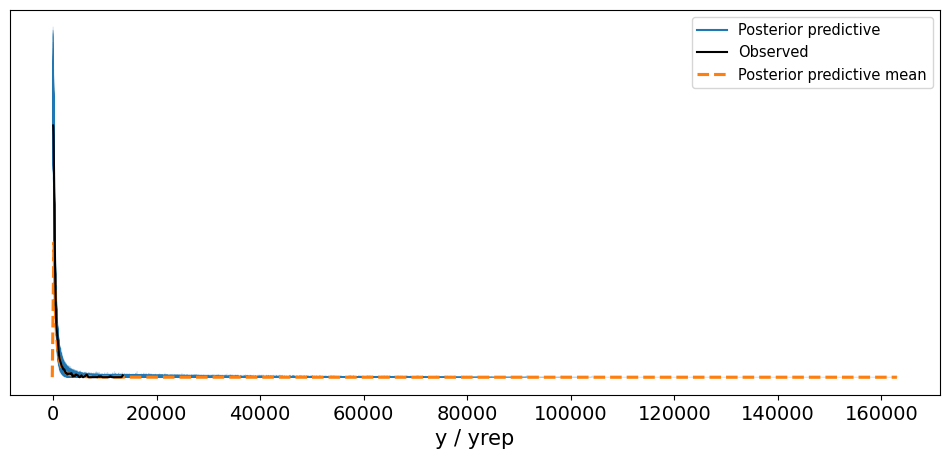

In [17]:
f, ax = plt.subplots(figsize=[12, 5])

az.plot_ppc(
    idatas["q2-pressure"],
    data_pairs={"y":"yrep"},
    coords={"measurement_type": "diameter"},
    var_names=["y"], 
    ax=ax,
    group="posterior"
);

[]

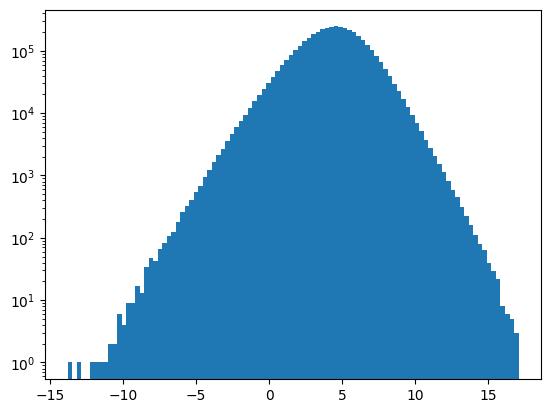

In [18]:
f, ax = plt.subplots()
ax.hist(np.log(idatas["q2-pressure"].prior_predictive["yrep"].values.flatten()), bins=100);
ax.semilogy()

The next cell plots the differences in age effects for each measurement type in the basic model. 

The plots show that, according to the basic model, diameter power harmonics tended to be higher for adult mice while center harmonics tended to be higher for old mice.

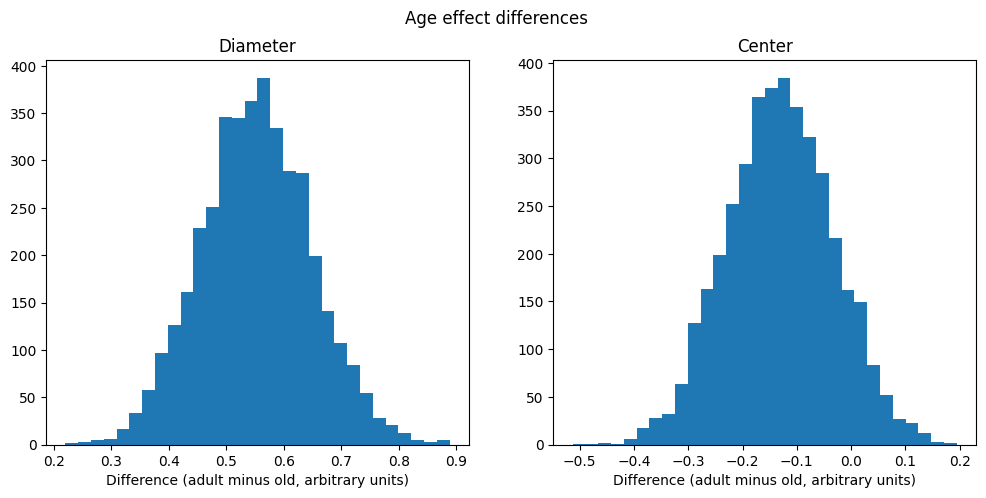

In [19]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Age effect differences")
for ax, mt in zip(axes, ["diameter", "center"]):
    comp = idatas["q2-pressure"].posterior["mu"].sel(measurement_type=mt, age="adult").values.flatten()
    base = idatas["q2-pressure"].posterior["mu"].sel(measurement_type=mt, age="old").values.flatten()
    ax.hist(comp - base, bins=30)
    ax.set(title=mt.capitalize(), xlabel="Difference (adult minus old, arbitrary units)")
f.savefig(os.path.join(PLOTS_DIR, "q2-age-effects.png"), bbox_inches="tight")

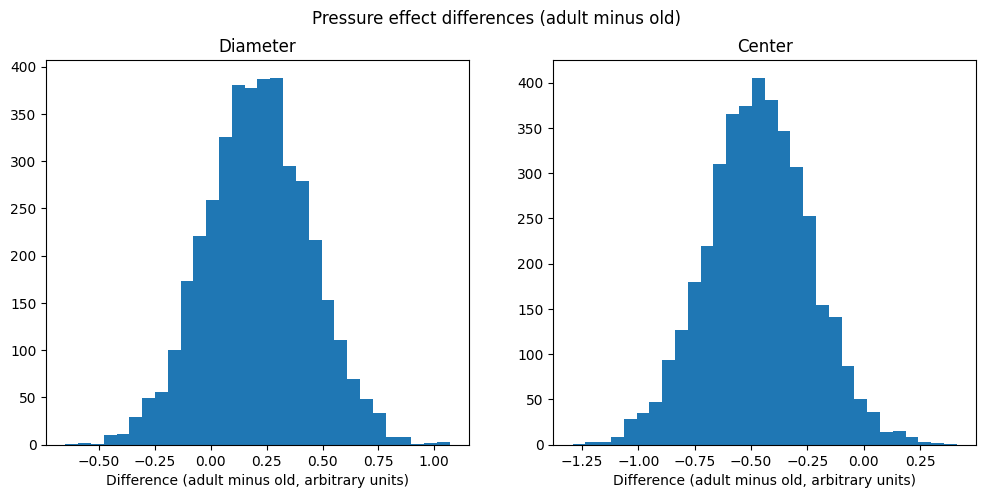

In [20]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Pressure effect differences (adult minus old)")
for ax, mt in zip(axes, ["diameter", "center"]):
    comp = idatas["q2-pressure"].posterior["b_pressure"].sel(measurement_type=mt, age="adult").values.flatten()
    base = idatas["q2-pressure"].posterior["b_pressure"].sel(measurement_type=mt, age="old").values.flatten()
    ax.hist(comp - base, bins=30)
    ax.set(title=mt.capitalize(), xlabel="Difference (adult minus old, arbitrary units)")
f.savefig(os.path.join(PLOTS_DIR, "q2-pressure-effects.png"), bbox_inches="tight")

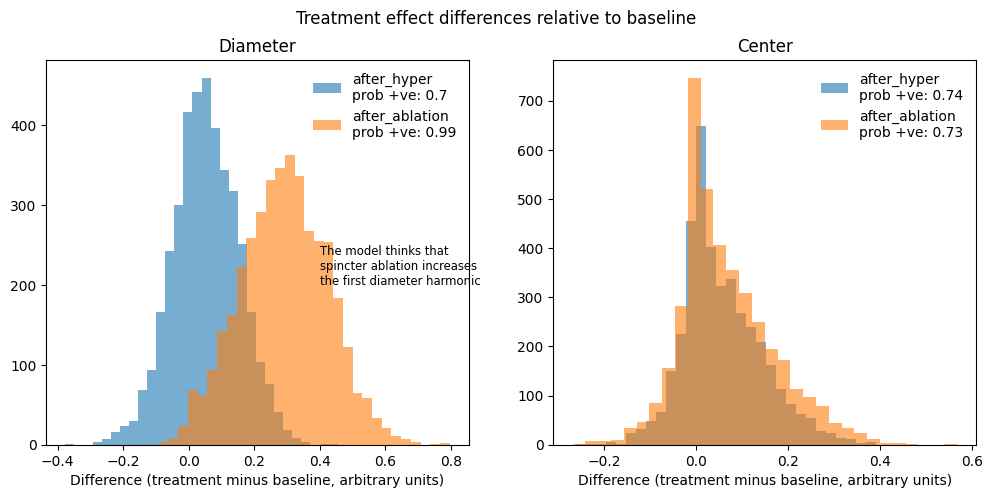

In [25]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Treatment effect differences relative to baseline")
for ax, mt in zip(axes, ["diameter", "center"]):
    for treatment in mts["treatment"].cat.remove_unused_categories().cat.categories:
        if treatment != "baseline":
            comp = idatas["q2-pressure"].posterior["a_treatment"].sel(measurement_type=mt, treatment=treatment).values.flatten()
            base = idatas["q2-pressure"].posterior["a_treatment"].sel(measurement_type=mt, treatment="baseline").values.flatten()
            pr = ((comp - base) > 0).mean()
            ax.hist(comp - base, bins=30, alpha=0.6, label=treatment + f"\nprob +ve: {pr.round(2)}");
    ax.set(title=mt.capitalize(), xlabel="Difference (treatment minus baseline, arbitrary units)")
    ax.legend(frameon=False)
axes[0].text(0.4, 200, "The model thinks that\nspincter ablation increases\nthe first diameter harmonic", fontsize="small");
f.savefig(os.path.join(PLOTS_DIR, "q2-treatment-effects.png"), bbox_inches="tight")

There is probably a relationship between the diameter and center pulsatility. This is because the tissue around the vessel is likely not uniform in stiffness: in this case the vessel does not expand and contract uniformly in all directions, so the center moves due to this. The movement of the center therefore has two components: the macro component due to the pressure waves that propagate through the brain and the micro component due to non-isotropic surrounding tissue.

Maybe there should be an effect of absolute diameter, as the treatments tend to change this. As the diameter increases, the vessel becomes less elastic, which you might expect to reduce the pulsatility.